In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from functools import partial
import os

# from ray import tune
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [3]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = datasets.FashionMNIST(data_dir, download=False, train=True, transform=transform)
    testset = datasets.FashionMNIST(data_dir, download=False, train=False, transform=transform)
    validationset, testset = torch.utils.data.random_split(testset, lengths=(5000,5000))
    
    return trainset, testset, validationset

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 2070 with Max-Q Design'

In [5]:
trainset, testset, validationset = load_data()

In [6]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
def manager(model, loader, mode, criterion, device, optimizer):
    model.to(device)
    loss = 0.0
    accuracy = []
    
    if mode == 'train':
        model.train()
    else:
        model.eval()
    
    for i, data in enumerate(loader, 0):    
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(mode == 'train'):
            # forward + backward + optimize
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss_ = criterion(outputs, labels)
            
            loss += loss_.item()
            accuracy.append((torch.sum(preds == labels.data)/len(preds)).cpu())
            
            if mode == 'train':
                loss_.backward()
                optimizer.step()
    
    return model, loss/len(loader), np.mean(accuracy)
        

def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

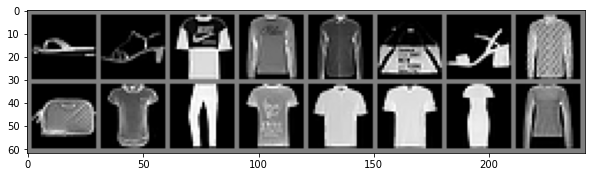

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.figure(figsize=(10,8))
imshow(torchvision.utils.make_grid(images[:16]))

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    # define forward function
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # conv 2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        # don't need softmax here since we'll use cross-entropy as activation.

        return t

net = Network()

In [10]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
net.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [12]:
train_losses = []
validation_losses = []
train_acc = []
validation_acc = []
phase = ['train', 'validation']

EPOCHS = 20

for epoch in range(1,EPOCHS+1):    
    for p in phase:
        loader = trainloader if p == 'train' else validationloader
        net, l, a = manager(net, loader, p, criterion, device, optimizer)
        
        if p == 'train':
            train_losses.append(l)
            train_acc.append(a)
        else:
            validation_losses.append(l)
            validation_acc.append(a)
    # if epoch%5 == 0:
    print(f"EPOCH {epoch}")
    print(f"Train loss: {train_losses[epoch-1]}")
    print(f"Train accuracy: {train_acc[epoch-1]}")
    print(f"Validation loss: {validation_losses[epoch-1]}")
    print(f"Validation accuracy: {validation_acc[epoch-1]}")
    print("---------------------")
    

print('Finished Training')

EPOCH 1
Train loss: 0.5761167509717245
Train accuracy: 0.7854333519935608
Validation loss: 0.42840851861983537
Validation accuracy: 0.8515625
---------------------
EPOCH 2
Train loss: 0.37828487685943646
Train accuracy: 0.8601332902908325
Validation loss: 0.37770536467432975
Validation accuracy: 0.860156238079071
---------------------
EPOCH 3
Train loss: 0.3302930892733857
Train accuracy: 0.8784666061401367
Validation loss: 0.33492379561066626
Validation accuracy: 0.8734375238418579
---------------------
EPOCH 4
Train loss: 0.30458699745560686
Train accuracy: 0.8867666125297546
Validation loss: 0.32798734977841376
Validation accuracy: 0.873828113079071
---------------------
EPOCH 5
Train loss: 0.28634766601088146
Train accuracy: 0.8932666182518005
Validation loss: 0.3393642334267497
Validation accuracy: 0.8775390386581421
---------------------
EPOCH 6
Train loss: 0.26944936555996535
Train accuracy: 0.8991166949272156
Validation loss: 0.32015933389775453
Validation accuracy: 0.882617175

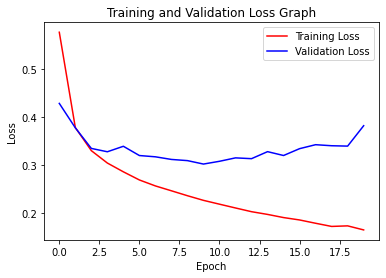

In [13]:
plt.plot(train_losses, label='Training Loss', color='r')
plt.plot(validation_losses, label='Validation Loss', color='b')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Graph")
plt.legend()
plt.show()

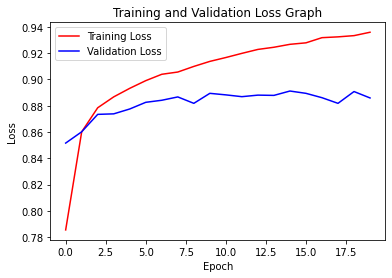

In [14]:
plt.plot(train_acc, label='Training Loss', color='r')
plt.plot(validation_acc, label='Validation Loss', color='b')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Graph")
plt.legend()
plt.show()

In [15]:
net = Network()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_losses = []
validation_losses = []
train_acc = []
validation_acc = []
phase = ['train', 'validation']

EPOCHS = 3

for epoch in range(1,EPOCHS+1):    
    for p in phase:
        loader = trainloader if p == 'train' else validationloader
        net, l, a = manager(net, loader, p, criterion, device, optimizer)
        
        if p == 'train':
            train_losses.append(l)
            train_acc.append(a)
        else:
            validation_losses.append(l)
            validation_acc.append(a)
    # if epoch%5 == 0:
    print(f"EPOCH {epoch}")
    print(f"Train loss: {train_losses[epoch-1]}")
    print(f"Train accuracy: {train_acc[epoch-1]}")
    print(f"Validation loss: {validation_losses[epoch-1]}")
    print(f"Validation accuracy: {validation_acc[epoch-1]}")
    print("---------------------")
    

print('Finished Training')

EPOCH 1
Train loss: 0.5415130717443923
Train accuracy: 0.7972999811172485
Validation loss: 0.4142086561769247
Validation accuracy: 0.847460925579071
---------------------
EPOCH 2
Train loss: 0.36843439625638225
Train accuracy: 0.8655166029930115
Validation loss: 0.3565268791280687
Validation accuracy: 0.8705078363418579
---------------------
EPOCH 3
Train loss: 0.3265456933391591
Train accuracy: 0.8798500299453735
Validation loss: 0.33628165861591697
Validation accuracy: 0.8773437738418579
---------------------
Finished Training


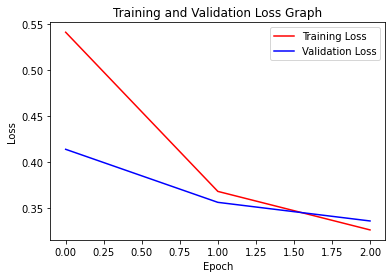

In [16]:
plt.plot(train_losses, label='Training Loss', color='r')
plt.plot(validation_losses, label='Validation Loss', color='b')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Graph")
plt.legend()
plt.show()

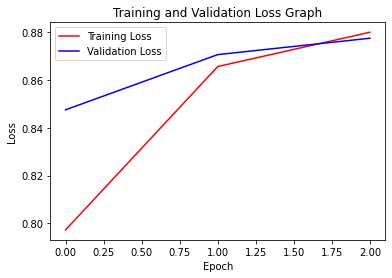

In [17]:
plt.plot(train_acc, label='Training Loss', color='r')
plt.plot(validation_acc, label='Validation Loss', color='b')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Graph")
plt.legend()
plt.show()

In [18]:
def train_mnist(config, checkpoint_dir=None, data_dir=None):
    net = Network()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset, validation = load_data(data_dir)

    # test_abs = int(len(trainset) * 0.8)
    # train_subset, val_subset = random_split(
        # trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        validationset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [19]:
config = {
    "lr" : tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([32, 64, 128, 256]),
}

In [20]:
def test_accuracy(net, device="cpu"):
    _, testset, _ = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [21]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=0):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    config = {
        "lr" : tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([32, 64, 128, 256]),
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        parameter_columns=["lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_mnist, data_dir=data_dir),
        resources_per_trial={"cpu": 8, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Network()
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))

In [22]:
main()

2022-06-08 21:04:29,969	INFO trial_runner.py:803 -- starting train_mnist_de1ce_00000


== Status ==
Current time: 2022-06-08 21:04:30 (running for 00:00:01.06)
Memory usage on this node: 4.0/7.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 8.0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+---------------------+-------------+--------------+
| Trial name              | status   | loc                 |          lr |   batch_size |
|-------------------------+----------+---------------------+-------------+--------------|
| train_mnist_de1ce_00000 | RUNNING  | 192.168.142.62:3189 | 0.0701448   |           64 |
| train_mnist_de1ce_00001 | PENDING  |                     | 0.00334754  |          256 |
| train_mnist_de1ce_00002 | PENDING  |                     | 0.0290594   |           32 |
| train_mnist_de1ce_000

2022-06-08 21:06:11,073	INFO trial_runner.py:803 -- starting train_mnist_de1ce_00001


== Status ==
Current time: 2022-06-08 21:06:16 (running for 00:01:46.93)
Memory usage on this node: 4.3/7.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -2.308440474015248 | Iter 4.000: -2.3052200486388386 | Iter 2.000: -2.3049222547796706 | Iter 1.000: -2.305755075020126
Resources requested: 8.0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+------------+---------------------+-------------+--------------+---------+------------+----------------------+
| Trial name              | status     | loc                 |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|-------------------------+------------+---------------------+-------------+--------------+---------+------------+----------------------|
| train_mnist_de1ce_00001 | RUNNING    | 192.168.142.62:5640 | 0.00334754  | 

2022-06-08 21:07:21,091	INFO trial_runner.py:803 -- starting train_mnist_de1ce_00002


== Status ==
Current time: 2022-06-08 21:07:26 (running for 00:02:57.02)
Memory usage on this node: 4.3/7.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -1.3103189645170035 | Iter 4.000: -1.3194772521717637 | Iter 2.000: -1.3660208391143551 | Iter 1.000: -1.426164447120096
Resources requested: 8.0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+------------+---------------------+-------------+--------------+---------+------------+----------------------+
| Trial name              | status     | loc                 |          lr |   batch_size |    loss |   accuracy |   training_iteration |
|-------------------------+------------+---------------------+-------------+--------------+---------+------------+----------------------|
| train_mnist_de1ce_00002 | RUNNING    | 192.168.142.62:8084 | 0.0290594   |

2022-06-08 21:07:36,094	INFO trial_runner.py:803 -- starting train_mnist_de1ce_00003


Result for train_mnist_de1ce_00002:
  accuracy: 0.548
  date: 2022-06-08_21-07-36
  done: true
  experiment_id: 5712ef4e498d4bbe88a58264aa38f115
  hostname: Ahmadreza
  iterations_since_restore: 1
  loss: 1.6495289510222757
  node_ip: 192.168.142.62
  pid: 8084
  should_checkpoint: true
  time_since_restore: 12.589656829833984
  time_this_iter_s: 12.589656829833984
  time_total_s: 12.589656829833984
  timestamp: 1654706256
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: de1ce_00002
  warmup_time: 0.0029959678649902344
  
== Status ==
Current time: 2022-06-08 21:07:41 (running for 00:03:11.95)
Memory usage on this node: 4.3/7.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -1.3103189645170035 | Iter 4.000: -1.3194772521717637 | Iter 2.000: -1.3660208391143551 | Iter 1.000: -1.6495289510222757
Resources requested: 8.0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number

2022-06-08 21:08:57,106	INFO trial_runner.py:803 -- starting train_mnist_de1ce_00004


== Status ==
Current time: 2022-06-08 21:09:02 (running for 00:04:32.98)
Memory usage on this node: 4.3/7.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.32462881207466127 | Iter 4.000: -0.35224447548389437 | Iter 2.000: -0.42711942344903947 | Iter 1.000: -1.0980513851211708
Resources requested: 8.0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name              | status     | loc                  |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------|
| train_mnist_de1ce_00004 | RUNNING    | 192.168.142.62:10804 | 0.

2022-06-08 21:09:18,111	INFO trial_runner.py:803 -- starting train_mnist_de1ce_00005


== Status ==
Current time: 2022-06-08 21:09:18 (running for 00:04:48.98)
Memory usage on this node: 4.0/7.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.32462881207466127 | Iter 4.000: -0.35224447548389437 | Iter 2.000: -0.5274957549251333 | Iter 1.000: -0.7418178312386139
Resources requested: 8.0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name              | status     | loc                  |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------|
| train_mnist_de1ce_00005 | RUNNING    | 192.168.142.62:11319 | 0.0

2022-06-08 21:09:55,115	INFO trial_runner.py:803 -- starting train_mnist_de1ce_00006


== Status ==
Current time: 2022-06-08 21:10:00 (running for 00:05:30.98)
Memory usage on this node: 4.3/7.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.32462881207466127 | Iter 4.000: -0.36205019527409654 | Iter 2.000: -0.42711942344903947 | Iter 1.000: -0.64419582522934
Resources requested: 8.0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name              | status     | loc                  |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------|
| train_mnist_de1ce_00006 | RUNNING    | 192.168.142.62:12316 | 0.02

2022-06-08 21:10:12,121	INFO trial_runner.py:803 -- starting train_mnist_de1ce_00007


== Status ==
Current time: 2022-06-08 21:10:17 (running for 00:05:48.00)
Memory usage on this node: 4.3/7.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.32462881207466127 | Iter 4.000: -0.36205019527409654 | Iter 2.000: -0.5274957549251333 | Iter 1.000: -0.564032056927681
Resources requested: 8.0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name              | status     | loc                  |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------|
| train_mnist_de1ce_00007 | RUNNING    | 192.168.142.62:12828 | 0.00

2022-06-08 21:12:15,141	INFO trial_runner.py:803 -- starting train_mnist_de1ce_00008


== Status ==
Current time: 2022-06-08 21:12:20 (running for 00:07:51.02)
Memory usage on this node: 4.3/7.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.31841313354671 | Iter 4.000: -0.35224447548389437 | Iter 2.000: -0.42711942344903947 | Iter 1.000: -0.5553029380738735
Resources requested: 8.0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name              | status     | loc                  |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------|
| train_mnist_de1ce_00008 | RUNNING    | 192.168.142.62:15297 | 0.017

2022-06-08 21:12:35,137	INFO trial_runner.py:803 -- starting train_mnist_de1ce_00009


== Status ==
Current time: 2022-06-08 21:12:40 (running for 00:08:10.99)
Memory usage on this node: 4.3/7.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.31841313354671 | Iter 4.000: -0.35224447548389437 | Iter 2.000: -0.4566683067268209 | Iter 1.000: -0.5465738192200661
Resources requested: 8.0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------+
| Trial name              | status     | loc                  |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|-------------------------+------------+----------------------+-------------+--------------+----------+------------+----------------------|
| train_mnist_de1ce_00009 | RUNNING    | 192.168.142.62:15812 | 0.0323956   |    

2022-06-08 21:12:44,007	INFO tune.py:701 -- Total run time: 494.93 seconds (494.70 seconds for the tuning loop).


Result for train_mnist_de1ce_00009:
  accuracy: 0.716
  date: 2022-06-08_21-12-43
  done: true
  experiment_id: 43f206590b1f4ea9adfa63f973a8eafb
  hostname: Ahmadreza
  iterations_since_restore: 1
  loss: 0.7205371901392936
  node_ip: 192.168.142.62
  pid: 15812
  should_checkpoint: true
  time_since_restore: 6.95342493057251
  time_this_iter_s: 6.95342493057251
  time_total_s: 6.95342493057251
  timestamp: 1654706563
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: de1ce_00009
  warmup_time: 0.0023369789123535156
  
== Status ==
Current time: 2022-06-08 21:12:43 (running for 00:08:14.71)
Memory usage on this node: 4.1/7.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -0.31841313354671 | Iter 4.000: -0.35224447548389437 | Iter 2.000: -0.4566683067268209 | Iter 1.000: -0.5553029380738735
Resources requested: 0/12 CPUs, 0/0 GPUs, 0.0/2.92 GiB heap, 0.0/1.46 GiB objects
Result logdir: /home/ahmadreza/ray_results/train_mnist_2022-06-08_21-04-29
Number of tri